In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score
import sklearn.metrics as metrics

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder

from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('train_dataset.csv', low_memory=False)

<Axes: >

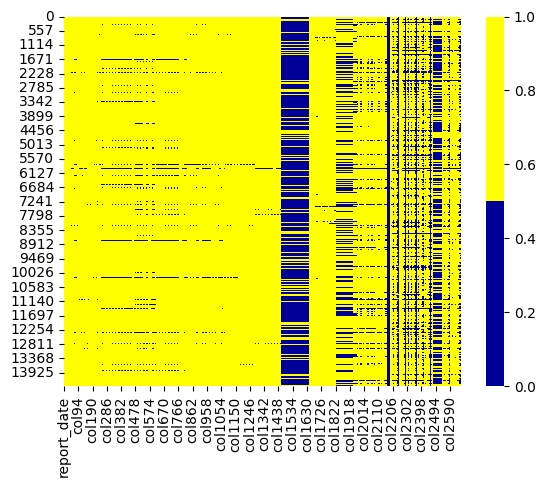

In [18]:
cols = train.columns # первые 30 колонок
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(train[cols].isnull(), cmap=sns.color_palette(colours))

In [3]:
def remove_repetitions(first_list, second_list):
    return [element for element in first_list if element not in second_list]

=================================================== ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ДАННЫХ ===================================================

In [4]:
cat_cols = [col for col in train.columns if train[col].dtype == 'object']
cat_cols.pop(0)

train_cat = train[cat_cols]
train_cat = train_cat.fillna('')


train_cat_np = train_cat.to_numpy()

for i in range(len(train_cat_np)):
    for j in range(len(train_cat_np[i])):
        el = train_cat_np[i][j]
        if isinstance(el, int):
            continue

        if el != "":
            if "https" in el:
                new_i = el[el.find("//")+2:]
                new_i = new_i[:new_i.find("/")]
                train_cat_np[i][j] = new_i
train_cat = pd.DataFrame(train_cat_np, columns=cat_cols)

In [5]:
train_cat = train_cat.apply(LabelEncoder().fit_transform)

In [6]:
corr_matrix = train_cat.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

train_cat.drop(to_drop, axis=1, inplace=True)

cat_cols = remove_repetitions(cat_cols, to_drop)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ДАННЫХ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

=================================================== ОБРАБОТКА ЧИСЛЕННЫХ ДАННЫХ ===================================================

In [7]:
num_cols = [col for col in train.columns if train[col].dtype != 'object']
num_cols.pop(1)
train_num = train[num_cols]
train_num = train_num.fillna(0)  # try mediana

In [8]:
corr_matrix = train_num.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

train_num.drop(to_drop, axis=1, inplace=True)

num_cols = remove_repetitions(num_cols, to_drop)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ОБРАБОТКА ЧИСЛЕННЫХ ДАННЫХ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [9]:
# СОЕДИНЕНИЕ ОБРАБОТАННЫХ ДАННЫХ
train_norm = train_num.join(train_cat)

In [10]:
stand_sc = StandardScaler()

# data_ohe = pd.DataFrame(onehotencoder.fit_transform(train[cat_cols]))
data_num_cols = stand_sc.fit_transform(train_norm[num_cols])
data_cat_cols = stand_sc.fit_transform(train_cat[cat_cols])
data_norm = pd.DataFrame(data_num_cols, columns=num_cols)
data_norm = data_norm.join(pd.DataFrame(data_cat_cols, columns=cat_cols))

y = train['target'].values
X = data_norm[data_norm.columns[:-1]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=62, stratify=y)
print(np.unique(y_train), np.unique(y_test))

[0 1] [0 1]


In [11]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter=1000)
dictionary = {'C':range(1,20,1)}
grid = GridSearchCV(logReg, dictionary)
grid.fit(X_train, y_train)
grid.best_estimator_

LogisticRegression(C=1, max_iter=1000)

In [12]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

DT = DecisionTreeClassifier()
dictionary = {'criterion':['entropy', 'log_loss','gini'], 'max_depth':range(2,20,1),
              'max_features':range(10,40,5), 'min_samples_split':range(2,20,1)}
randomized = RandomizedSearchCV(DT, dictionary, n_iter=50)
randomized.fit(X_train, y_train)
randomized.best_estimator_

DecisionTreeClassifier(criterion='log_loss', max_depth=3, max_features=10,
                       min_samples_split=18)

In [13]:
RF = RandomForestClassifier()
dictionary = {'n_estimators':range(10,110,10), 'criterion':['entropy', 'log_loss','gini'],
              'max_depth':range(2,20,1), 'max_features':range(10,40,5), 'min_samples_split':range(2,20,1)}
randomized = RandomizedSearchCV(RF, dictionary, n_iter=10)
randomized.fit(X_train, y_train)
randomized.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=13, max_features=30,
                       min_samples_split=6)

In [14]:
NB = BernoulliNB()
dictionary = {'alpha':[0.00001,0.00005,0.0001,0.0005,0.001,0.05,0.01,0.05,0.1,0.5]}
grid = GridSearchCV(NB, dictionary)
grid.fit(X_train, y_train)
grid.best_estimator_

BernoulliNB(alpha=1e-05)

In [15]:
svc = SVC(gamma='scale')
dictionary = {'kernel':['sigmoid', 'rbf', 'poly'], 'C':[0.5,1,2,3], 'degree':[2,3,4,5]}
grid = GridSearchCV(svc, dictionary)
grid.fit(X_train, y_train)
grid.best_estimator_

SVC(C=3, degree=2)

In [16]:
KNN = KNeighborsClassifier()
dictionary = {'n_neighbors':range(1,12,2), 'weights':['uniform', 'distance']}
grid = GridSearchCV(KNN, dictionary)
grid.fit(X_train, y_train)
grid.best_estimator_

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [21]:
logReg = LogisticRegression(C=19, max_iter=1000)

DT = DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=15,
                       min_samples_split=14)

RF = RandomForestClassifier(criterion='log_loss', max_depth=17, max_features=25,
                       min_samples_split=10, n_estimators=300)

NB = BernoulliNB(alpha=1e-05)

svc = SVC(C=3, degree=2)

KNN = KNeighborsClassifier(n_neighbors=70, weights='distance')

VC = VotingClassifier(estimators=[('LogisticRegression', logReg), ('DecisionTreeClassifier', DT),
          ('RandomForestClassifier', RF),('BernoulliNB' , NB), ('SVC' , svc), ('KNeighborsClassifier',KNN)])

In [22]:
Models = {'LogisticRegression':logReg,
          'DecisionTreeClassifier':DT,
          'RandomForestClassifier': RF,
          'BernoulliNB' : NB,
          'SVC' : svc,
          'KNeighborsClassifier' : KNN,
          'VotingClassifier' : VC
         }

In [23]:
best_val_model = None
best_val_score = 0.0
for model in Models.keys(): 
    #Model Fitting
    Models[model].fit(X_train, y_train)
    print(str(model).center(30))
    
    #_______________________________________________________
    #Prediction
    y_pred = Models[model].predict(X_test)
    
    #_______________________________________________________
    #metrices
    result = roc_auc_score(y_test, y_pred)
    print(result)
    #_______________________________________________________
    #Score
    print('Training Score:', Models[model].score(X_train, y_train))
    print('Validation Score:', Models[model].score(X_test, y_test))
    
    #_______________________________________________________
    if best_val_score < result:
        best_val_score = result
        best_val_model = model
        
    #_______________________________________________________
    print()
    print('AUC_score', result)
    print('==========================================================')

d:\FrequentUsageFolder\Coding\Python\samolet\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


      LogisticRegression      
0.5259266088880693
Training Score: 0.9773434797647873
Validation Score: 0.9553941908713693

AUC_score 0.5259266088880693
    DecisionTreeClassifier    
0.5
Training Score: 0.9703389830508474
Validation Score: 0.9699170124481328

AUC_score 0.5
    RandomForestClassifier    
0.5287356321839081
Training Score: 0.9768246281563473
Validation Score: 0.9716459197786999

AUC_score 0.5287356321839081
         BernoulliNB          
0.6165652467883705
Training Score: 0.8097544102386718
Validation Score: 0.7963347164591977

AUC_score 0.6165652467883705
             SVC              
0.5113159997541337
Training Score: 0.9766516776202007
Validation Score: 0.9702627939142462

AUC_score 0.5113159997541337
     KNeighborsClassifier     
0.5114942528735632
Training Score: 1.0
Validation Score: 0.9706085753803596

AUC_score 0.5114942528735632


d:\FrequentUsageFolder\Coding\Python\samolet\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


       VotingClassifier       
0.5057471264367817
Training Score: 0.9770840539605673
Validation Score: 0.9702627939142462

AUC_score 0.5057471264367817
